In [1]:
import geopandas as gpd
import pandas as pd

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh

from SimPEG.utils import plot2Ddata, surface2ind_topo
from SimPEG.potential_fields import gravity
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)



In [1]:
#sagrav = gpd.read_file(r'C:\users\rscott\Downloads\gravity_stations_shp\gravity_stations.shp')  

In [3]:
print(sagrav['MGA_ZONE'].unique())
sagrav.head()

[54 53 52]


,SURVEY_NAM,BA_1984_MG,BASE_STATI,OG_ORIGINA,OG_UNIT,OG_1965_MG,OG_1984_UM,BA_1965_MG,BA_1984_UM,NOTES,SURVEY_COD,STATION_ID,MGA_EAST,MGA_NORTH,MGA_ZONE,LONGITUDE,LATITUDE,AHD_ELEVAT,OG_1984_MG,geometry
0,LEIGH CREEK NORTH (1948E0),-28.989,None,979299.20,1965_mgals,979299.20,9792848.398,-28.380,-289.895,H 23,1948E0,823,253947.68,6652415.74,54,138.443229,-30.234936,145.080002,979284.840,POINT (138.44322 -30.23495)
1,LEIGH CREEK NORTH (1948E0),-28.115,None,979299.92,1965_mgals,979299.92,9792855.595,-27.504,-281.147,G 23,1948E0,723,253972.72,6651602.12,54,138.443298,-30.242276,148.800003,979285.560,POINT (138.44329 -30.24229)
2,LEIGH CREEK NORTH (1948E0),-26.205,None,979301.43,1965_mgals,979301.43,9792870.694,-25.593,-262.050,RD 6.5,1948E0,13,254242.84,6650981.48,54,138.445958,-30.247926,153.089996,979287.069,POINT (138.44595 -30.24794)
3,LEIGH CREEK NORTH (1948E0),-28.686,None,979299.26,1965_mgals,979299.26,9792848.996,-28.075,-286.857,G 24,1948E0,724,254803.12,6651635.19,54,138.451929,-30.242146,149.199997,979284.900,POINT (138.45192 -30.24216)
4,LEIGH CREEK NORTH (1948E0),-27.196,None,979300.79,1965_mgals,979300.79,9792864.295,-26.585,-271.965,RD 7.0,1948E0,14,254923.58,6651330.63,54,138.453109,-30.244916,150.100006,979286.429,POINT (138.45310 -30.24493)


In [4]:
#survey_array = sagrav[['LONGITUDE','LATITUDE','AHD_ELEVAT','BA_1984_UM']].to_numpy()
survey_array = sagrav[['MGA_EAST','MGA_NORTH','AHD_ELEVAT','BA_1984_UM']].to_numpy()

In [5]:
dobs = survey_array

In [6]:
survey_array.shape

(683592, 4)

In [7]:
dobs.shape

(683592, 4)

In [8]:
#dobs_total_bounds = [sagrav['MGA_EAST'].min(),sagrav['MGA_NORTH'].min(),sagrav['MGA_EAST'].max(),sagrav['MGA_NORTH'].max()]
dobs_total_bounds = sagrav.total_bounds
print(dobs_total_bounds)
sa54 = sagrav.loc[sagrav['MGA_ZONE'] == 54]

[128.50132321 -39.99733438 141.49972995 -25.50001403]


In [9]:
dobs_total_bounds
minx, miny, maxx, maxy = dobs_total_bounds
minx = sa54['MGA_EAST'].min()
maxx = sa54['MGA_EAST'].max()
miny = sa54['MGA_NORTH'].min()
maxy = sa54['MGA_NORTH'].max()

minxtest = maxx - 0.045
minxtest = maxx - 5000
maxxtest = maxx
minytest = maxy - 0.045
minytest = maxy - 5000
maxytest = maxy

print(minxtest, maxxtest, minytest, maxytest)


544587.6900000001 549587.6900000001 7174103.37 7179103.37


In [10]:
# Define receiver locations and observed data
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

In [11]:
#sagrav_test = sagrav.loc[(sagrav['MGA_EAST'] >= minxtest) & (sagrav['MGA_EAST'] <= maxxtest) & (sagrav['MGA_NORTH'] >= minytest) & (sagrav['MGA_NORTH'] <= maxytest) ]
from tqdm import tqdm
from time import sleep

#print(minxtest, minytest, maxxtest, maxytest)
print(minx, miny, maxx, maxy)
#maxrangey = (maxy - miny)//0.045
#maxrangex = (maxx - minx)//0.045

maxrangey = (maxy - miny)//5000
maxrangex = (maxx - minx)//5000

print(maxrangex, maxrangey)
#with tqdm(total=maxrangey) as pbar:
for i in range(int(maxrangey)):
    print(i)
    for j in range(int(maxrangex)):

        #xmin, ymin, xmax, ymax = sagrav_test.total_bounds
        #xmin = minx + j*0.045
        #ymin = miny + i*0.045
        #xmax = minx + (j+1)*0.045
        #ymax = miny + (i+1)*0.045
        
        xmin = minx + j*5000
        ymin = miny + i*5000
        xmax = minx + (j+1)*5000
        ymax = miny + (i+1)*5000
        print(xmin, ymin, xmax, ymax)

        #sagrav_test = sagrav.loc[(sagrav['LONGITUDE'] >= xmin) & (sagrav['LATITUDE'] >= ymin) & (sagrav['LONGITUDE'] <= xmax) & (sagrav['LATITUDE'] <= ymax) ]
        sagrav_test = sa54.loc[(sa54['MGA_EAST'] >= xmin) & (sa54['MGA_NORTH'] >= ymin) & (sa54['MGA_EAST'] <= xmax) & (sa54['MGA_NORTH'] <= ymax) ]
        
        #sac_sussex = sagrav.cx[xmin:xmax, ymin:ymax]    
        #print(sagrav_test.shape)
        if (sagrav_test.shape[0] > 0):
            #print(sagrav_test)
            break
    if (sagrav_test.shape[0] > 3):
        print(sagrav_test)
        break

print(minx, miny, maxx, maxy, sagrav_test.shape)
print(sagrav_test.total_bounds)

print(xmin, xmax, ymin, ymax)
ncx = 10
ncy = 10
ncz = 5
#dx = 0.0045*2
#dy = 0.0045*2
dx = 500
dy = 500
dz = 200

x0 = xmin
y0 = ymin
z0 = -1000
hx = dx*np.ones(ncx)
hy = dy*np.ones(ncy)
hz = dz*np.ones(ncz)

mesh2 = TensorMesh([hx, hx, hz], x0 = [x0,y0,z0])
mesh2


198845.79 5568582.51 549587.6900000001 7179103.37
70.0 322.0
0
198845.79 5568582.51 203845.79 5573582.51
203845.79 5568582.51 208845.79 5573582.51
208845.79 5568582.51 213845.79 5573582.51
213845.79 5568582.51 218845.79 5573582.51
218845.79 5568582.51 223845.79 5573582.51
223845.79 5568582.51 228845.79 5573582.51
228845.79 5568582.51 233845.79 5573582.51
233845.79 5568582.51 238845.79 5573582.51
238845.79 5568582.51 243845.79 5573582.51
243845.79 5568582.51 248845.79 5573582.51
1
198845.79 5573582.51 203845.79 5578582.51
203845.79 5573582.51 208845.79 5578582.51
208845.79 5573582.51 213845.79 5578582.51
213845.79 5573582.51 218845.79 5578582.51
218845.79 5573582.51 223845.79 5578582.51
223845.79 5573582.51 228845.79 5578582.51
228845.79 5573582.51 233845.79 5578582.51
233845.79 5573582.51 238845.79 5578582.51
238845.79 5573582.51 243845.79 5578582.51
243845.79 5573582.51 248845.79 5578582.51
248845.79 5573582.51 253845.79 5578582.51
253845.79 5573582.51 258845.79 5578582.51
258845.79 5

373845.79000000004 5593582.51 378845.79000000004 5598582.51
378845.79000000004 5593582.51 383845.79000000004 5598582.51
383845.79000000004 5593582.51 388845.79000000004 5598582.51
388845.79000000004 5593582.51 393845.79000000004 5598582.51
393845.79000000004 5593582.51 398845.79000000004 5598582.51
398845.79000000004 5593582.51 403845.79000000004 5598582.51
6
198845.79 5598582.51 203845.79 5603582.51
203845.79 5598582.51 208845.79 5603582.51
208845.79 5598582.51 213845.79 5603582.51
213845.79 5598582.51 218845.79 5603582.51
218845.79 5598582.51 223845.79 5603582.51
223845.79 5598582.51 228845.79 5603582.51
228845.79 5598582.51 233845.79 5603582.51
233845.79 5598582.51 238845.79 5603582.51
238845.79 5598582.51 243845.79 5603582.51
243845.79 5598582.51 248845.79 5603582.51
248845.79 5598582.51 253845.79 5603582.51
253845.79 5598582.51 258845.79 5603582.51
258845.79 5598582.51 263845.79000000004 5603582.51
263845.79000000004 5598582.51 268845.79000000004 5603582.51
268845.79000000004 5598

253845.79 5633582.51 258845.79 5638582.51
258845.79 5633582.51 263845.79000000004 5638582.51
263845.79000000004 5633582.51 268845.79000000004 5638582.51
268845.79000000004 5633582.51 273845.79000000004 5638582.51
273845.79000000004 5633582.51 278845.79000000004 5638582.51
278845.79000000004 5633582.51 283845.79000000004 5638582.51
283845.79000000004 5633582.51 288845.79000000004 5638582.51
288845.79000000004 5633582.51 293845.79000000004 5638582.51
14
198845.79 5638582.51 203845.79 5643582.51
203845.79 5638582.51 208845.79 5643582.51
208845.79 5638582.51 213845.79 5643582.51
213845.79 5638582.51 218845.79 5643582.51
218845.79 5638582.51 223845.79 5643582.51
223845.79 5638582.51 228845.79 5643582.51
228845.79 5638582.51 233845.79 5643582.51
233845.79 5638582.51 238845.79 5643582.51
238845.79 5638582.51 243845.79 5643582.51
243845.79 5638582.51 248845.79 5643582.51
248845.79 5638582.51 253845.79 5643582.51
253845.79 5638582.51 258845.79 5643582.51
258845.79 5638582.51 263845.79000000004 

30
198845.79 5718582.51 203845.79 5723582.51
203845.79 5718582.51 208845.79 5723582.51
208845.79 5718582.51 213845.79 5723582.51
213845.79 5718582.51 218845.79 5723582.51
218845.79 5718582.51 223845.79 5723582.51
223845.79 5718582.51 228845.79 5723582.51
228845.79 5718582.51 233845.79 5723582.51
233845.79 5718582.51 238845.79 5723582.51
238845.79 5718582.51 243845.79 5723582.51
31
198845.79 5723582.51 203845.79 5728582.51
203845.79 5723582.51 208845.79 5728582.51
208845.79 5723582.51 213845.79 5728582.51
213845.79 5723582.51 218845.79 5728582.51
218845.79 5723582.51 223845.79 5728582.51
223845.79 5723582.51 228845.79 5728582.51
228845.79 5723582.51 233845.79 5728582.51
233845.79 5723582.51 238845.79 5728582.51
238845.79 5723582.51 243845.79 5728582.51
243845.79 5723582.51 248845.79 5728582.51
32
198845.79 5728582.51 203845.79 5733582.51
203845.79 5728582.51 208845.79 5733582.51
208845.79 5728582.51 213845.79 5733582.51
213845.79 5728582.51 218845.79 5733582.51
218845.79 5728582.51 2238

203845.79 5828582.51 208845.79 5833582.51
208845.79 5828582.51 213845.79 5833582.51
213845.79 5828582.51 218845.79 5833582.51
218845.79 5828582.51 223845.79 5833582.51
223845.79 5828582.51 228845.79 5833582.51
228845.79 5828582.51 233845.79 5833582.51
233845.79 5828582.51 238845.79 5833582.51
238845.79 5828582.51 243845.79 5833582.51
243845.79 5828582.51 248845.79 5833582.51
53
198845.79 5833582.51 203845.79 5838582.51
203845.79 5833582.51 208845.79 5838582.51
208845.79 5833582.51 213845.79 5838582.51
213845.79 5833582.51 218845.79 5838582.51
218845.79 5833582.51 223845.79 5838582.51
223845.79 5833582.51 228845.79 5838582.51
228845.79 5833582.51 233845.79 5838582.51
233845.79 5833582.51 238845.79 5838582.51
54
198845.79 5838582.51 203845.79 5843582.51
203845.79 5838582.51 208845.79 5843582.51
208845.79 5838582.51 213845.79 5843582.51
213845.79 5838582.51 218845.79 5843582.51
218845.79 5838582.51 223845.79 5843582.51
223845.79 5838582.51 228845.79 5843582.51
228845.79 5838582.51 233845.

223845.79 5948582.51 228845.79 5953582.51
228845.79 5948582.51 233845.79 5953582.51
233845.79 5948582.51 238845.79 5953582.51
238845.79 5948582.51 243845.79 5953582.51
243845.79 5948582.51 248845.79 5953582.51
77
198845.79 5953582.51 203845.79 5958582.51
203845.79 5953582.51 208845.79 5958582.51
208845.79 5953582.51 213845.79 5958582.51
213845.79 5953582.51 218845.79 5958582.51
218845.79 5953582.51 223845.79 5958582.51
223845.79 5953582.51 228845.79 5958582.51
228845.79 5953582.51 233845.79 5958582.51
78
198845.79 5958582.51 203845.79 5963582.51
203845.79 5958582.51 208845.79 5963582.51
208845.79 5958582.51 213845.79 5963582.51
213845.79 5958582.51 218845.79 5963582.51
218845.79 5958582.51 223845.79 5963582.51
223845.79 5958582.51 228845.79 5963582.51
228845.79 5958582.51 233845.79 5963582.51
79
198845.79 5963582.51 203845.79 5968582.51
203845.79 5963582.51 208845.79 5968582.51
208845.79 5963582.51 213845.79 5968582.51
213845.79 5963582.51 218845.79 5968582.51
218845.79 5963582.51 2238

TensorMesh: 500 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     10    228,845.79    233,845.79    500.00    500.00    1.00
   y     10  6,018,582.51  6,023,582.51    500.00    500.00    1.00
   z      5     -1,000.00          0.00    200.00    200.00    1.00

In [12]:
sagrav_test

,SURVEY_NAM,BA_1984_MG,BASE_STATI,OG_ORIGINA,OG_UNIT,OG_1965_MG,OG_1984_UM,BA_1965_MG,BA_1984_UM,NOTES,SURVEY_COD,STATION_ID,MGA_EAST,MGA_NORTH,MGA_ZONE,LONGITUDE,LATITUDE,AHD_ELEVAT,OG_1984_MG,geometry
51676,KINGSCOTE,14.537,None,979830.69,1965_mgals,979830.69,9798162.752,16.428,145.367,PDH4,1968E4,429,233134.05,6023199.74,54,138.043196,-35.899130,39.990002,979816.275,POINT (138.04319 -35.89914)
52284,KINGSCOTE,15.497,None,979831.33,1965_mgals,979831.33,9798169.151,17.388,154.966,PDH2,1968E4,430,232080.50,6023077.81,54,138.031496,-35.899940,41.970001,979816.915,POINT (138.03149 -35.89995)
52583,KINGSCOTE,15.146,None,979830.50,1965_mgals,979830.50,9798160.852,17.038,151.463,None,1968E4,431,232237.32,6022972.62,54,138.033196,-35.900929,44.840000,979816.085,POINT (138.03319 -35.90094)
52585,KINGSCOTE,15.397,None,979831.59,1965_mgals,979831.59,9798171.752,17.289,153.970,PDH3,1968E4,432,232407.19,6023032.20,54,138.035096,-35.900439,40.360001,979817.175,POINT (138.03509 -35.90045)


In [13]:
survey_array_test = sagrav_test[['LONGITUDE','LATITUDE','AHD_ELEVAT','BA_1984_UM']].to_numpy()
print(survey_array_test.shape)
dobs_test = survey_array_test
receiver_locations_test = dobs_test[:, 0:3]
dobs_test = dobs_test[:, -1]

(4, 4)


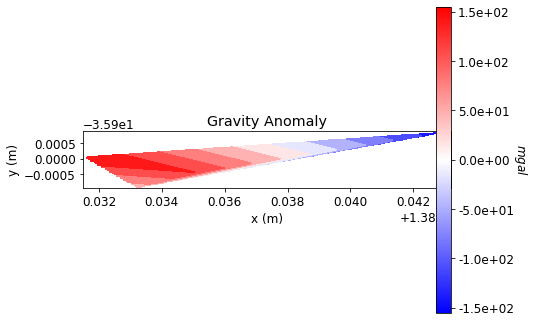

In [14]:
# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations_test, dobs_test, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Gravity Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.8, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dobs_test)), vmax=np.max(np.abs(dobs_test)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [15]:
dobs_test.shape

(4,)

In [16]:
sagrav_test

,SURVEY_NAM,BA_1984_MG,BASE_STATI,OG_ORIGINA,OG_UNIT,OG_1965_MG,OG_1984_UM,BA_1965_MG,BA_1984_UM,NOTES,SURVEY_COD,STATION_ID,MGA_EAST,MGA_NORTH,MGA_ZONE,LONGITUDE,LATITUDE,AHD_ELEVAT,OG_1984_MG,geometry
51676,KINGSCOTE,14.537,None,979830.69,1965_mgals,979830.69,9798162.752,16.428,145.367,PDH4,1968E4,429,233134.05,6023199.74,54,138.043196,-35.899130,39.990002,979816.275,POINT (138.04319 -35.89914)
52284,KINGSCOTE,15.497,None,979831.33,1965_mgals,979831.33,9798169.151,17.388,154.966,PDH2,1968E4,430,232080.50,6023077.81,54,138.031496,-35.899940,41.970001,979816.915,POINT (138.03149 -35.89995)
52583,KINGSCOTE,15.146,None,979830.50,1965_mgals,979830.50,9798160.852,17.038,151.463,None,1968E4,431,232237.32,6022972.62,54,138.033196,-35.900929,44.840000,979816.085,POINT (138.03319 -35.90094)
52585,KINGSCOTE,15.397,None,979831.59,1965_mgals,979831.59,9798171.752,17.289,153.970,PDH3,1968E4,432,232407.19,6023032.20,54,138.035096,-35.900439,40.360001,979817.175,POINT (138.03509 -35.90045)


In [17]:
maximum_anomaly = np.max(np.abs(dobs_test))

uncertainties = 0.01 * maximum_anomaly * np.ones(np.shape(dobs_test))            

In [18]:
print(i)

90


In [19]:
# Define the receivers. The data consist of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations_test, components="gz")

receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

In [20]:
receiver_list

In [21]:
data_object = data.Data(survey, dobs=dobs_test, standard_deviation=uncertainties)

In [22]:
data_object

In [24]:
mesh2
#source_field

TensorMesh: 500 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     10    228,845.79    233,845.79    500.00    500.00    1.00
   y     10  6,018,582.51  6,023,582.51    500.00    500.00    1.00
   z      5     -1,000.00          0.00    200.00    200.00    1.00

In [25]:
# Define density contrast values for each unit in g/cc. Don't make this 0!
# Otherwise the gradient for the 1st iteration is zero and the inversion will
# not converge.
background_density = 1e-6

# Find the indecies of the active cells in forward model (ones below surface)
#ind_active = surface2ind_topo(mesh, xyz_topo)
topo_fake = receiver_locations_test + 399
print(receiver_locations_test)
print(topo_fake)
ind_active = surface2ind_topo(mesh2, receiver_locations_test)
#ind_active = surface2ind_topo(mesh2, topo_fake)
#ind_active = surface2ind_topo(mesh2, topo_fake)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model consists of a value for each active cell

# Define and plot starting model
starting_model = background_density * np.ones(nC)

[[138.0431963  -35.8991295   39.99000168]
 [138.0314963  -35.8999395   41.97000122]
 [138.0331963  -35.9009295   44.84000015]
 [138.0350963  -35.9004395   40.36000061]]
[[537.0431963  363.1008705  438.99000168]
 [537.0314963  363.1000605  440.97000122]
 [537.0331963  363.0990705  443.84000015]
 [537.0350963  363.0995605  439.36000061]]


In [26]:
nC

500

In [27]:
model_map

In [28]:
ind_active

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [29]:
starting_model

array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
      

In [30]:
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey, mesh=mesh2, rhoMap=model_map, actInd=ind_active
)

In [31]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

# Define the regularization (model objective function).
reg = regularization.Simple(mesh2, indActive=ind_active, mapping=model_map)

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=10, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [32]:
dmis.nD

4

In [33]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Defining the fractional decrease in beta and the number of Gauss-Newton solves
# for each beta value.
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(everyIter=False)

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
    target_misfit,
]    

In [34]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model = inv.run(starting_model)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.81e-21  1.91e+04  0.00e+00  1.91e+04    4.18e-07      0              
------------------------- STOP! -------------------------
0 : |fc-fOld| = 1.0000e+00 <= tolF*(1+|f0|) = 0.0000e+00
0 : |xc-x_last| = 1.0000e+00 <= tolX*(1+|x0|) = 0.0000e+00
1 : |proj(x-g)-x|    = 4.1762e-07 <= tolG          = 1.0000e-01
1 : |proj(x-g)-x|    = 4.1762e-07 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter          =      0
------------------------- DONE! -------------------------


In [ ]:

# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh2, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
#ax1 = fig.add_axes([10.1, 10.1, 73.73, 80.8])
mesh2.plotSlice(
    plotting_map * recovered_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh2.nCy / 2),
    grid=True,
    clim=(np.min(recovered_model), np.max(recovered_model)),
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(recovered_model), vmax=np.max(recovered_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

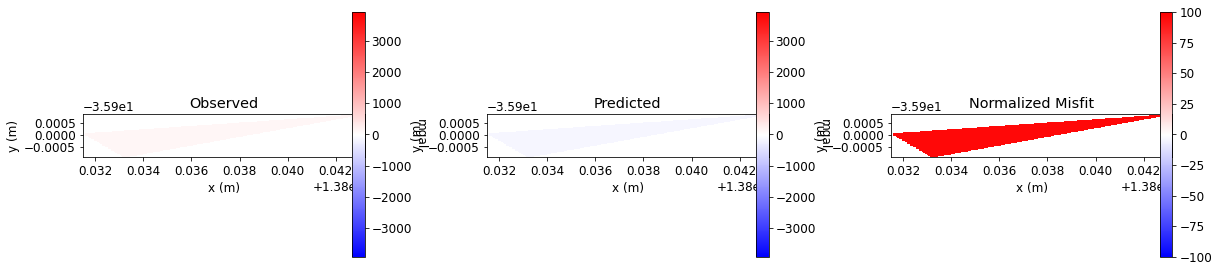

In [40]:
dpred = inv_prob.dpred

# Observed data | Predicted data | Normalized data misfit
data_array = np.c_[dobs_test, dpred, (dobs_test - dpred) / uncertainties]

fig = plt.figure(figsize=(17, 4))
plot_title = ["Observed", "Predicted", "Normalized Misfit"]
plot_units = ["mgal", "mgal", ""]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(data_array[:, 2]))]

for ii in range(0, 3):

    ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.11, 0.23, 0.84])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        clim=(-v_lim[ii], v_lim[ii]),
        contourOpts={"cmap": "bwr"},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("y (m)")

    ax2[ii] = fig.add_axes([0.33 * ii + 0.25, 0.11, 0.01, 0.85])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="vertical", cmap=mpl.cm.bwr
    )
    cbar[ii].set_label(plot_units[ii], rotation=270, labelpad=15, size=12)

plt.show()


In [39]:
dpred

array([-3.9781928e-16, -3.9781928e-16, -3.9781928e-16, -2.9836446e-16])

In [2]:
data_source = "https://storage.googleapis.com/simpeg/doc-assets/gravity.tar.gz"

# download the data
downloaded_data = utils.download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "gravity_topo.txt"
data_filename = dir_path + "gravity_data.obs"
model_filename = dir_path + "true_model.txt"

   saved to: C:\Users\rscott\OneDrive - OZ Minerals\Exploration2021\Invert-the-Gawler\gravity.tar.gz
Download completed!


In [3]:
xyz_topo = np.loadtxt(str(topo_filename))


In [4]:
xyz_topo.shape

(1681, 3)

In [5]:
xyzdobs = np.loadtxt(str(data_filename))

In [6]:
xyzdobs.shape

(289, 4)

In [7]:
xyz_topo[1]

array([-2.0000e+02, -1.9000e+02, -1.0282e-04])

In [8]:
xyzdobs[0]

array([-8.0000e+01, -8.0000e+01,  2.9700e+00,  8.7145e-04])

In [10]:
xyzdobs

array([[-8.0000e+01, -8.0000e+01,  2.9700e+00,  8.7145e-04],
       [-7.0000e+01, -8.0000e+01,  2.4338e+00,  8.2583e-04],
       [-6.0000e+01, -8.0000e+01,  1.8558e+00,  9.4978e-04],
       ...,
       [ 6.0000e+01,  8.0000e+01,  1.8558e+00, -5.9197e-04],
       [ 7.0000e+01,  8.0000e+01,  2.4338e+00, -5.6868e-04],
       [ 8.0000e+01,  8.0000e+01,  2.9700e+00, -5.6579e-04]])

In [260]:
sagrav_test

,SURVEY_NAM,BA_1984_MG,BASE_STATI,OG_ORIGINA,OG_UNIT,OG_1965_MG,OG_1984_UM,BA_1965_MG,BA_1984_UM,NOTES,SURVEY_COD,STATION_ID,MGA_EAST,MGA_NORTH,MGA_ZONE,LONGITUDE,LATITUDE,AHD_ELEVAT,OG_1984_MG,geometry
69916,GREAT VICTORIA DESEST,-33.363,None,979407.100,1965_mgals,979407.100,9793927.092,-32.451,-333.626,None,197002,181,500770.61,6511071.86,52,129.008118,-31.535291,100.489998,979392.709,POINT (129.00811 -31.53530)
676163,PACE COPPER COOMPANA GRAVITY SURVEY,-32.927,None,979392.671,1984_mgals,979407.062,9793926.710,-32.015,-329.265,None,2017A1,5001127,501202.34,6510990.80,52,129.012666,-31.536022,103.199997,979392.671,POINT (129.01266 -31.53604)
676594,PACE COPPER COOMPANA GRAVITY SURVEY,-31.318,None,979391.234,1984_mgals,979405.624,9793912.340,-30.415,-313.179,None,2017A1,5001331,502037.44,6514996.66,52,129.021455,-31.499878,103.889999,979391.234,POINT (129.02145 -31.49989)
676609,PACE COPPER COOMPANA GRAVITY SURVEY,-31.996,None,979392.803,1984_mgals,979407.194,9793928.030,-31.086,-319.960,None,2017A1,5001334,501983.88,6512013.90,52,129.020897,-31.526790,103.480003,979392.803,POINT (129.02089 -31.52680)
676621,PACE COPPER COOMPANA GRAVITY SURVEY,-32.988,None,979392.456,1984_mgals,979406.847,9793924.560,-32.076,-329.879,None,2017A1,5001335,501993.38,6511037.12,52,129.020999,-31.535603,103.809998,979392.456,POINT (129.02099 -31.53562)
677019,PACE COPPER COOMPANA GRAVITY SURVEY,-31.721,None,979393.210,1984_mgals,979407.601,9793932.100,-30.811,-317.208,None,2017A1,5001360,503006.93,6512027.29,52,129.031673,-31.526667,102.760002,979393.210,POINT (129.03166 -31.52668)
677039,PACE COPPER COOMPANA GRAVITY SURVEY,-31.105,None,979393.099,1984_mgals,979407.489,9793930.990,-30.198,-311.054,None,2017A1,5001361,502953.59,6513070.59,52,129.031108,-31.517254,102.599998,979393.099,POINT (129.03110 -31.51727)
677042,PACE COPPER COOMPANA GRAVITY SURVEY,-30.659,None,979391.554,1984_mgals,979405.944,9793915.540,-29.755,-306.586,None,2017A1,5001363,502960.44,6515111.59,52,129.031174,-31.498839,105.190002,979391.554,POINT (129.03117 -31.49885)
677046,PACE COPPER COOMPANA GRAVITY SURVEY,-31.189,None,979392.924,1984_mgals,979407.314,9793929.240,-30.281,-311.890,None,2017A1,5001333,502038.67,6512996.22,52,129.021472,-31.517927,103.339996,979392.924,POINT (129.02146 -31.51794)
679193,PACE COPPER COOMPANA GRAVITY SURVEY,-31.178,None,979392.302,1984_mgals,979406.692,9793923.020,-30.273,-311.784,None,2017A1,5001362,502961.93,6514040.38,52,129.031193,-31.508504,102.699997,979392.302,POINT (129.03118 -31.50852)


In [261]:
dobs_test

array([-333.626, -329.265, -313.179, -319.96 , -329.879, -317.208,
       -311.054, -306.586, -311.89 , -311.784, -318.701, -324.812,
       -322.371, -315.686, -315.452, -306.245])

In [262]:
survey_array_test[0]

array([ 129.0081178 ,  -31.5352912 ,  100.48999786, -333.626     ])

In [263]:
receiver_locations_test[0]

array([129.0081178 , -31.5352912 , 100.48999786])

In [265]:
print(survey)

In [273]:
survey.nD

16

In [274]:
data

<module 'SimPEG.data' from 'C:\\Users\\rscott\\miniconda3\\envs\\avant2\\lib\\site-packages\\SimPEG\\data.py'>

In [275]:
data.noise_floor

AttributeError: module 'SimPEG.data' has no attribute 'noise_floor'

In [277]:
mesh2

TensorMesh: 1,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     10        129.00        129.04      0.00      0.00    1.00
   y     10        -31.54        -31.49      0.00      0.00    1.00
   z     10       -500.00          0.00     50.00     50.00    1.00

TypeError: 'TensorMesh' object is not subscriptable

In [306]:
xyzdobs

array([[-8.0000e+01, -8.0000e+01,  2.9700e+00,  8.7145e-04],
       [-7.0000e+01, -8.0000e+01,  2.4338e+00,  8.2583e-04],
       [-6.0000e+01, -8.0000e+01,  1.8558e+00,  9.4978e-04],
       ...,
       [ 6.0000e+01,  8.0000e+01,  1.8558e+00, -5.9197e-04],
       [ 7.0000e+01,  8.0000e+01,  2.4338e+00, -5.6868e-04],
       [ 8.0000e+01,  8.0000e+01,  2.9700e+00, -5.6579e-04]])

In [307]:
recovered_model

array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
      

In [3]:
from SimPEG.utils import plot2Ddata, surface2ind_topo

ModuleNotFoundError: No module named 'SimPEG'